<a href="https://colab.research.google.com/github/TamBui1706/DeepLearningCourse/blob/main/Week05/Week05.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CIFAR-10 Image Classification with Deep Learning

In [36]:
#Video demo project
from IPython.display import HTML
from base64 import b64encode

mp4 = open(video_path, 'rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()

HTML(f"""
<video width=640 height=480 controls loop>
  <source src="{data_url}" type="video/mp4">
</video>
""")


# 1. Setup and Imports

In [1]:
!pip install wandb
!pip install gradio
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
from torch.utils.data import DataLoader, Subset, random_split

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
import random
import wandb
import gradio as gr
from collections import defaultdict
import copy

# Set seeds for reproducibility
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.backends.cudnn.deterministic = True

set_seed()

# Check if CUDA is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.1/54.1 MB 15.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.9/322.9 kB 16.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.5/11.5 MB 70.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 3.8 MB/s eta 0:00:00
Using device: cpu


# 2. Data Preparation

100%|██████████| 170M/170M [00:11<00:00, 14.9MB/s]


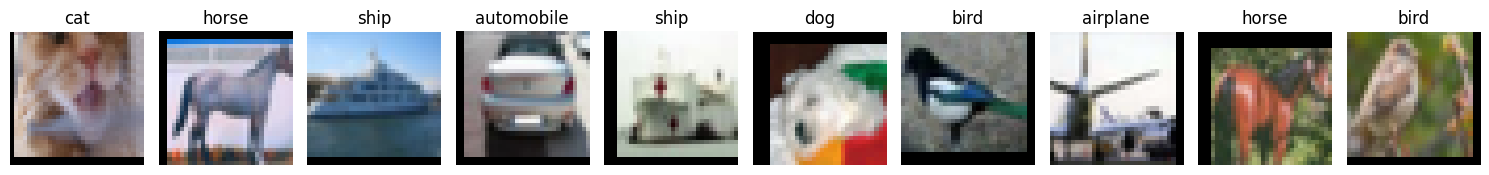

In [2]:
# Define transformations for data augmentation and normalization
def get_transforms(is_train=True):
    if is_train:
        transform = transforms.Compose([
            transforms.RandomHorizontalFlip(),
            transforms.RandomCrop(32, padding=4),
            transforms.ToTensor(),
            transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616))
        ])
    else:
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616))
        ])
    return transform

# Load dataset and split into train, validation, test
def load_cifar10(batch_size=128):
    train_transform = get_transforms(is_train=True)
    val_test_transform = get_transforms(is_train=False)

    # Load full training set with train transforms
    full_train_dataset = torchvision.datasets.CIFAR10(
        root='./data',
        train=True,
        download=True,
        transform=train_transform
    )

    # Load test set
    test_dataset = torchvision.datasets.CIFAR10(
        root='./data',
        train=False,
        download=True,
        transform=val_test_transform
    )

    # Split training set into training and validation
    train_size = int(0.9 * len(full_train_dataset))
    val_size = len(full_train_dataset) - train_size

    # Use random_split to split the dataset
    train_dataset, val_dataset = random_split(
        full_train_dataset,
        [train_size, val_size]
    )

    # Create new validation dataset with validation transforms
    val_dataset_correct_transform = Subset(
        torchvision.datasets.CIFAR10(
            root='./data',
            train=True,
            download=True,
            transform=val_test_transform
        ),
        val_dataset.indices
    )

    # Create data loaders
    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=2,
        pin_memory=True
    )

    val_loader = DataLoader(
        val_dataset_correct_transform,
        batch_size=batch_size,
        shuffle=False,
        num_workers=2,
        pin_memory=True
    )

    test_loader = DataLoader(
        test_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=2,
        pin_memory=True
    )

    return train_loader, val_loader, test_loader

# Class names for CIFAR-10
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

# Visualize some examples from the dataset
def visualize_samples(dataloader, num_samples=10):
    dataiter = iter(dataloader)
    images, labels = next(dataiter)
    images = images[:num_samples]
    labels = labels[:num_samples]

    # Display images
    fig, axes = plt.subplots(1, num_samples, figsize=(15, 3))
    for i, ax in enumerate(axes):
        # Denormalize the images
        img = images[i].numpy().transpose((1, 2, 0))
        mean = np.array([0.4914, 0.4822, 0.4465])
        std = np.array([0.2470, 0.2435, 0.2616])
        img = std * img + mean
        img = np.clip(img, 0, 1)

        ax.imshow(img)
        ax.set_title(class_names[labels[i]])
        ax.axis('off')

    plt.tight_layout()
    plt.show()

# Load the data
train_loader, val_loader, test_loader = load_cifar10()

# Visualize sample images
visualize_samples(train_loader)

# 3. Basic CNN Model

In [3]:
class BasicCNN(nn.Module):
    def __init__(self):
        super(BasicCNN, self).__init__()
        self.name = "BasicCNN"

        # Feature extraction
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)

        # Pooling layers
        self.pool = nn.MaxPool2d(2, 2)

        # Fully connected layers
        self.fc1 = nn.Linear(128 * 4 * 4, 512)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(512, 10)

    def forward(self, x, return_features=False):
        # Feature maps to store for visualization
        feature_maps = []

        # First convolutional block
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)
        feature_maps.append(x.detach())
        x = self.pool(x)

        # Second convolutional block
        x = self.conv2(x)
        x = self.bn2(x)
        x = F.relu(x)
        feature_maps.append(x.detach())
        x = self.pool(x)

        # Third convolutional block
        x = self.conv3(x)
        x = self.bn3(x)
        x = F.relu(x)
        feature_maps.append(x.detach())
        x = self.pool(x)

        # Flatten
        x = x.view(-1, 128 * 4 * 4)

        # Fully connected layers
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        outputs = self.fc2(x)

        if return_features:
            return outputs, feature_maps
        else:
            return outputs

# 4. Advanced Models

In [4]:
class CustomResNet(nn.Module):
    def __init__(self, num_classes=10):
        super(CustomResNet, self).__init__()
        self.name = "CustomResNet"

        # Load pre-trained ResNet18 and modify for CIFAR-10
        self.model = models.resnet18(weights='DEFAULT')

        # Replace the first convolutional layer to handle 32x32 images
        self.model.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.model.maxpool = nn.Identity()  # Remove maxpool

        # Change final fully connected layer for 10 classes
        self.model.fc = nn.Linear(self.model.fc.in_features, num_classes)

        # Save intermediate activations for feature visualization
        self.activation = {}
        self.hooks = []

        # Register hooks to get activations
        for name, layer in [
            ('layer1', self.model.layer1),
            ('layer2', self.model.layer2),
            ('layer3', self.model.layer3),
        ]:
            self.hooks.append(
                layer.register_forward_hook(self._get_activation(name))
            )

    def _get_activation(self, name):
        def hook(model, input, output):
            self.activation[name] = output
        return hook

    def forward(self, x, return_features=False):
        output = self.model(x)

        if return_features:
            return output, [self.activation['layer1'],
                           self.activation['layer2'],
                           self.activation['layer3']]
        else:
            return output

In [5]:
class CustomEfficientNet(nn.Module):
    def __init__(self, num_classes=10):
        super(CustomEfficientNet, self).__init__()
        self.name = "CustomEfficientNet"

        # Load pre-trained EfficientNet
        self.model = models.efficientnet_b0(weights='DEFAULT')

        # Change the classifier for 10 classes
        self.model.classifier = nn.Sequential(
            nn.Dropout(p=0.2, inplace=True),
            nn.Linear(in_features=1280, out_features=num_classes)
        )

        # Save intermediate activations for feature visualization
        self.activation = {}
        self.hooks = []

        # Register hooks for getting intermediate activations
        for i, block in enumerate([2, 4, 6]):
            layer_name = f'features_{block}'
            self.hooks.append(
                self.model.features[block].register_forward_hook(self._get_activation(layer_name))
            )

    def _get_activation(self, name):
        def hook(model, input, output):
            self.activation[name] = output
        return hook

    def forward(self, x, return_features=False):
        output = self.model(x)

        if return_features:
            return output, [self.activation[f'features_{i}'] for i in [2, 4, 6]]
        else:
            return output

# 5. Training and Evaluation

In [6]:
def train_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in tqdm(dataloader, desc="Training", leave=False):
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)

        # Calculate accuracy
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    epoch_loss = running_loss / len(dataloader.dataset)
    epoch_acc = correct / total

    return epoch_loss, epoch_acc

def evaluate(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in tqdm(dataloader, desc="Evaluating", leave=False):
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * inputs.size(0)

            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    epoch_loss = running_loss / len(dataloader.dataset)
    epoch_acc = correct / total

    return epoch_loss, epoch_acc

def train_model(model, train_loader, val_loader, test_loader, config, wandb_log=True):
    # Setup for training
    criterion = nn.CrossEntropyLoss()

    if config['optimizer'] == 'adam':
        optimizer = optim.Adam(model.parameters(), lr=config['lr'], weight_decay=config['weight_decay'])
    elif config['optimizer'] == 'sgd':
        optimizer = optim.SGD(model.parameters(), lr=config['lr'],
                              momentum=0.9, weight_decay=config['weight_decay'])
    else:
        raise ValueError(f"Optimizer {config['optimizer']} not supported")

    # Learning rate scheduler
    if config['scheduler'] == 'cosine':
        scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=config['epochs'])
    elif config['scheduler'] == 'step':
        scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)
    elif config['scheduler'] == 'none':
        scheduler = None
    else:
        raise ValueError(f"Scheduler {config['scheduler']} not supported")

    # Initialize WandB for tracking
    if wandb_log:
        wandb.init(
            project="cifar10-classification",
            name=f"{model.name}_{config['optimizer']}_lr{config['lr']}_bs{config['batch_size']}",
            config=config
        )

    # Set batch size on loaders if different from default
    if train_loader.batch_size != config['batch_size']:
        train_loader = DataLoader(
            train_loader.dataset,
            batch_size=config['batch_size'],
            shuffle=True,
            num_workers=2,
            pin_memory=True
        )
        val_loader = DataLoader(
            val_loader.dataset,
            batch_size=config['batch_size'],
            shuffle=False,
            num_workers=2,
            pin_memory=True
        )

    # Training history
    history = {
        'train_loss': [],
        'train_acc': [],
        'val_loss': [],
        'val_acc': []
    }

    best_val_acc = 0.0
    best_model_wts = copy.deepcopy(model.state_dict())

    # Training loop
    for epoch in range(config['epochs']):
        # Train
        train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)

        # Validate
        val_loss, val_acc = evaluate(model, val_loader, criterion, device)

        # Update learning rate
        if scheduler:
            scheduler.step()

        # Save best model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_model_wts = copy.deepcopy(model.state_dict())

        # Log metrics
        print(f"Epoch {epoch+1}/{config['epochs']}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

        # Update history
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)

        # Log to WandB
        if wandb_log:
            wandb.log({
                'epoch': epoch,
                'train_loss': train_loss,
                'train_acc': train_acc,
                'val_loss': val_loss,
                'val_acc': val_acc,
                'lr': optimizer.param_groups[0]['lr']
            })

    # Load best model weights
    model.load_state_dict(best_model_wts)

    # Evaluate on test set
    test_loss, test_acc = evaluate(model, test_loader, criterion, device)
    print(f"Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}")

    if wandb_log:
        wandb.log({
            'test_loss': test_loss,
            'test_acc': test_acc
        })
        wandb.finish()

    return model, history, test_loss, test_acc

# Define hyperparameter configurations for each model
def get_hyperparameter_configs():
    basic_cnn_configs = [
        {
            'model_name': 'BasicCNN',
            'batch_size': 256,
            'lr': 0.005,
            'weight_decay': 5e-4,
            'optimizer': 'adam',
            'scheduler': 'cosine',
            'epochs': 10
        },
        {
            'model_name': 'BasicCNN',
            'batch_size': 512,
            'lr': 0.01,
            'weight_decay': 1e-4,
            'optimizer': 'sgd',
            'scheduler': 'step',
            'epochs': 10
        },
        {
            'model_name': 'BasicCNN',
            'batch_size': 128,
            'lr': 0.001,
            'weight_decay': 1e-3,
            'optimizer': 'adam',
            'scheduler': 'none',
            'epochs': 10
        }
    ]

    resnet_configs = [
        {
            'model_name': 'CustomResNet',
            'batch_size': 256,
            'lr': 0.005,
            'weight_decay': 5e-4,
            'optimizer': 'adam',
            'scheduler': 'cosine',
            'epochs': 5
        },
        {
            'model_name': 'CustomResNet',
            'batch_size': 512,
            'lr': 0.01,
            'weight_decay': 1e-4,
            'optimizer': 'sgd',
            'scheduler': 'step',
            'epochs': 5
        },
        {
            'model_name': 'CustomResNet',
            'batch_size': 128,
            'lr': 0.001,
            'weight_decay': 1e-3,
            'optimizer': 'adam',
            'scheduler': 'none',
            'epochs': 5
        }
    ]

    efficientnet_configs = [
        {
            'model_name': 'CustomEfficientNet',
            'batch_size': 256,
            'lr': 0.005,
            'weight_decay': 1e-4,
            'optimizer': 'adam',
            'scheduler': 'cosine',
            'epochs': 5
        },
        {
            'model_name': 'CustomEfficientNet',
            'batch_size': 512,
            'lr': 0.01,
            'weight_decay': 5e-4,
            'optimizer': 'sgd',
            'scheduler': 'step',
            'epochs': 5
        },
        {
            'model_name': 'CustomEfficientNet',
            'batch_size': 128,
            'lr': 0.001,
            'weight_decay': 1e-3,
            'optimizer': 'adam',
            'scheduler': 'none',
            'epochs': 5
        }
    ]

    return basic_cnn_configs, resnet_configs, efficientnet_configs

# 6. Run Training

In [7]:
def run_model_experiments():
    basic_cnn_configs, resnet_configs, efficientnet_configs = get_hyperparameter_configs()

    # Storage for results
    results = defaultdict(list)
    best_models = {}

    # Run BasicCNN experiments
    for config in basic_cnn_configs:
        print(f"\nTraining BasicCNN with config: {config}")
        model = BasicCNN().to(device)
        trained_model, history, test_loss, test_acc = train_model(
            model, train_loader, val_loader, test_loader, config
        )

        # Save results
        results['BasicCNN'].append({
            'config': config,
            'test_loss': test_loss,
            'test_acc': test_acc,
            'history': history
        })

        if 'BasicCNN' not in best_models or test_acc > best_models['BasicCNN']['test_acc']:
            best_models['BasicCNN'] = {
                'model': trained_model,
                'config': config,
                'test_acc': test_acc
            }

    # Run ResNet experiments
    # for config in resnet_configs:
    #     print(f"\nTraining CustomResNet with config: {config}")
    #     model = CustomResNet().to(device)
    #     trained_model, history, test_loss, test_acc = train_model(
    #         model, train_loader, val_loader, test_loader, config
    #     )

    #     # Save results
    #     results['CustomResNet'].append({
    #         'config': config,
    #         'test_loss': test_loss,
    #         'test_acc': test_acc,
    #         'history': history
    #     })

    #     if 'CustomResNet' not in best_models or test_acc > best_models['CustomResNet']['test_acc']:
    #         best_models['CustomResNet'] = {
    #             'model': trained_model,
    #             'config': config,
    #             'test_acc': test_acc
    #         }

    # Run EfficientNet experiments
    for config in efficientnet_configs:
        print(f"\nTraining CustomEfficientNet with config: {config}")
        model = CustomEfficientNet().to(device)
        trained_model, history, test_loss, test_acc = train_model(
            model, train_loader, val_loader, test_loader, config
        )

        # Save results
        results['CustomEfficientNet'].append({
            'config': config,
            'test_loss': test_loss,
            'test_acc': test_acc,
            'history': history
        })

        if 'CustomEfficientNet' not in best_models or test_acc > best_models['CustomEfficientNet']['test_acc']:
            best_models['CustomEfficientNet'] = {
                'model': trained_model,
                'config': config,
                'test_acc': test_acc
            }

    # Find the overall best model
    best_model_name = max(best_models.keys(), key=lambda k: best_models[k]['test_acc'])
    overall_best_model = best_models[best_model_name]

    print("\n==== Final Results ====")

    # Calculate statistics for each model type
    for model_name in results:
        accs = [r['test_acc'] for r in results[model_name]]
        mean_acc = np.mean(accs)
        std_acc = np.std(accs)

        losses = [r['test_loss'] for r in results[model_name]]
        mean_loss = np.mean(losses)
        std_loss = np.std(losses)

        print(f"{model_name}:")
        print(f"  Mean Test Accuracy: {mean_acc:.4f} ± {std_acc:.4f}")
        print(f"  Mean Test Loss: {mean_loss:.4f} ± {std_loss:.4f}")

    print("\nBest Overall Model:")
    print(f"  Model: {best_model_name}")
    print(f"  Config: {overall_best_model['config']}")
    print(f"  Test Accuracy: {overall_best_model['test_acc']:.4f}")

    # Save the best model
    torch.save(overall_best_model['model'].state_dict(), 'best_cifar10_model.pth')

    return results, best_models, overall_best_model

# Run all experiments
# (In practice, you might want to run this in a separate cell)
results, best_models, overall_best_model = run_model_experiments()


Training BasicCNN with config: {'model_name': 'BasicCNN', 'batch_size': 256, 'lr': 0.005, 'weight_decay': 0.0005, 'optimizer': 'adam', 'scheduler': 'cosine', 'epochs': 10}


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: builehongtamk16 (builehongtamk16-hi) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Training:   0%|          | 0/176 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1/10, Train Loss: 2.0322, Train Acc: 0.2908, Val Loss: 1.5704, Val Acc: 0.4190


Training:   0%|          | 0/176 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2/10, Train Loss: 1.6159, Train Acc: 0.3986, Val Loss: 1.3170, Val Acc: 0.5062


Training:   0%|          | 0/176 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3/10, Train Loss: 1.4496, Train Acc: 0.4647, Val Loss: 1.2281, Val Acc: 0.5574


Training:   0%|          | 0/176 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4/10, Train Loss: 1.3272, Train Acc: 0.5180, Val Loss: 1.1035, Val Acc: 0.6098


Training:   0%|          | 0/176 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 5/10, Train Loss: 1.2022, Train Acc: 0.5710, Val Loss: 1.0221, Val Acc: 0.6336


Training:   0%|          | 0/176 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 6/10, Train Loss: 1.1157, Train Acc: 0.6043, Val Loss: 0.8979, Val Acc: 0.6728


Training:   0%|          | 0/176 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 7/10, Train Loss: 1.0359, Train Acc: 0.6352, Val Loss: 0.8956, Val Acc: 0.6886


Training:   0%|          | 0/176 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 8/10, Train Loss: 0.9631, Train Acc: 0.6640, Val Loss: 0.7852, Val Acc: 0.7160


Training:   0%|          | 0/176 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 9/10, Train Loss: 0.9088, Train Acc: 0.6826, Val Loss: 0.7336, Val Acc: 0.7444


Training:   0%|          | 0/176 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 10/10, Train Loss: 0.8746, Train Acc: 0.6985, Val Loss: 0.7089, Val Acc: 0.7488


Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Test Loss: 0.7115, Test Acc: 0.7525


epoch,▁▂▃▃▄▅▆▆▇█
lr,█▇▇▆▅▃▂▂▁▁
test_acc,▁
test_loss,▁
train_acc,▁▃▄▅▆▆▇▇██
train_loss,█▅▄▄▃▂▂▂▁▁
val_acc,▁▃▄▅▆▆▇▇██
val_loss,█▆▅▄▄▃▃▂▁▁
epoch,9
lr,0
test_acc,0.7525



Training BasicCNN with config: {'model_name': 'BasicCNN', 'batch_size': 512, 'lr': 0.01, 'weight_decay': 0.0001, 'optimizer': 'sgd', 'scheduler': 'step', 'epochs': 10}


Training:   0%|          | 0/88 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1/10, Train Loss: 1.7558, Train Acc: 0.3503, Val Loss: 1.3821, Val Acc: 0.5048


Training:   0%|          | 0/88 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2/10, Train Loss: 1.3674, Train Acc: 0.4997, Val Loss: 1.1956, Val Acc: 0.5642


Training:   0%|          | 0/88 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3/10, Train Loss: 1.2234, Train Acc: 0.5621, Val Loss: 1.0541, Val Acc: 0.6194


Training:   0%|          | 0/88 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 4/10, Train Loss: 1.1205, Train Acc: 0.5981, Val Loss: 1.0112, Val Acc: 0.6368


Training:   0%|          | 0/88 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 5/10, Train Loss: 1.0434, Train Acc: 0.6259, Val Loss: 0.9160, Val Acc: 0.6726


Training:   0%|          | 0/88 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 6/10, Train Loss: 0.9957, Train Acc: 0.6475, Val Loss: 0.9151, Val Acc: 0.6770


Training:   0%|          | 0/88 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 7/10, Train Loss: 0.9486, Train Acc: 0.6632, Val Loss: 0.8190, Val Acc: 0.7158


Training:   0%|          | 0/88 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 8/10, Train Loss: 0.9079, Train Acc: 0.6807, Val Loss: 0.8036, Val Acc: 0.7138


Training:   0%|          | 0/88 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 9/10, Train Loss: 0.8780, Train Acc: 0.6896, Val Loss: 0.8016, Val Acc: 0.7194


Training:   0%|          | 0/88 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 10/10, Train Loss: 0.8476, Train Acc: 0.7005, Val Loss: 0.7698, Val Acc: 0.7302


Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Test Loss: 0.7627, Test Acc: 0.7297


epoch,▁▂▃▃▄▅▆▆▇█
lr,▁▁▁▁▁▁▁▁▁▁
test_acc,▁
test_loss,▁
train_acc,▁▄▅▆▇▇▇███
train_loss,█▅▄▃▃▂▂▁▁▁
val_acc,▁▃▅▅▆▆█▇██
val_loss,█▆▄▄▃▃▂▁▁▁
epoch,9
lr,0.01
test_acc,0.7297



Training BasicCNN with config: {'model_name': 'BasicCNN', 'batch_size': 128, 'lr': 0.001, 'weight_decay': 0.001, 'optimizer': 'adam', 'scheduler': 'none', 'epochs': 10}


Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 1/10, Train Loss: 1.5627, Train Acc: 0.4264, Val Loss: 1.3200, Val Acc: 0.5046


Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 2/10, Train Loss: 1.2266, Train Acc: 0.5580, Val Loss: 0.9966, Val Acc: 0.6368


Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 3/10, Train Loss: 1.0985, Train Acc: 0.6077, Val Loss: 0.9685, Val Acc: 0.6504


Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 4/10, Train Loss: 1.0274, Train Acc: 0.6369, Val Loss: 0.8895, Val Acc: 0.6902


Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 5/10, Train Loss: 0.9691, Train Acc: 0.6583, Val Loss: 0.7810, Val Acc: 0.7180


Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 6/10, Train Loss: 0.9224, Train Acc: 0.6755, Val Loss: 0.7576, Val Acc: 0.7330


Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 7/10, Train Loss: 0.8865, Train Acc: 0.6893, Val Loss: 0.7781, Val Acc: 0.7232


Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 8/10, Train Loss: 0.8568, Train Acc: 0.7022, Val Loss: 0.7579, Val Acc: 0.7312


Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 9/10, Train Loss: 0.8288, Train Acc: 0.7102, Val Loss: 0.7197, Val Acc: 0.7426


Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 10/10, Train Loss: 0.8064, Train Acc: 0.7200, Val Loss: 0.6936, Val Acc: 0.7598


Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Test Loss: 0.6945, Test Acc: 0.7629


epoch,▁▂▃▃▄▅▆▆▇█
lr,▁▁▁▁▁▁▁▁▁▁
test_acc,▁
test_loss,▁
train_acc,▁▄▅▆▇▇▇███
train_loss,█▅▄▃▃▂▂▁▁▁
val_acc,▁▅▅▆▇▇▇▇██
val_loss,█▄▄▃▂▂▂▂▁▁
epoch,9
lr,0.001
test_acc,0.7629



Training CustomEfficientNet with config: {'model_name': 'CustomEfficientNet', 'batch_size': 256, 'lr': 0.005, 'weight_decay': 0.0001, 'optimizer': 'adam', 'scheduler': 'cosine', 'epochs': 5}


Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 70.7MB/s]


Training:   0%|          | 0/176 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1/5, Train Loss: 1.1986, Train Acc: 0.5866, Val Loss: 0.8265, Val Acc: 0.7220


Training:   0%|          | 0/176 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2/5, Train Loss: 0.7908, Train Acc: 0.7316, Val Loss: 0.7433, Val Acc: 0.7452


Training:   0%|          | 0/176 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3/5, Train Loss: 0.6550, Train Acc: 0.7754, Val Loss: 0.6467, Val Acc: 0.7800


Training:   0%|          | 0/176 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4/5, Train Loss: 0.5334, Train Acc: 0.8164, Val Loss: 0.5031, Val Acc: 0.8278


Training:   0%|          | 0/176 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 5/5, Train Loss: 0.4397, Train Acc: 0.8477, Val Loss: 0.4288, Val Acc: 0.8492


Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Test Loss: 0.4492, Test Acc: 0.8459


epoch,▁▃▅▆█
lr,█▆▄▂▁
test_acc,▁
test_loss,▁
train_acc,▁▅▆▇█
train_loss,█▄▃▂▁
val_acc,▁▂▄▇█
val_loss,█▇▅▂▁
epoch,4
lr,0
test_acc,0.8459



Training CustomEfficientNet with config: {'model_name': 'CustomEfficientNet', 'batch_size': 512, 'lr': 0.01, 'weight_decay': 0.0005, 'optimizer': 'sgd', 'scheduler': 'step', 'epochs': 5}


Training:   0%|          | 0/88 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1/5, Train Loss: 1.7503, Train Acc: 0.3748, Val Loss: 1.3015, Val Acc: 0.5476


Training:   0%|          | 0/88 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2/5, Train Loss: 1.1501, Train Acc: 0.5971, Val Loss: 1.0152, Val Acc: 0.6480


Training:   0%|          | 0/88 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3/5, Train Loss: 0.9463, Train Acc: 0.6707, Val Loss: 0.8474, Val Acc: 0.7008


Training:   0%|          | 0/88 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 4/5, Train Loss: 0.8340, Train Acc: 0.7086, Val Loss: 0.7539, Val Acc: 0.7312


Training:   0%|          | 0/88 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 5/5, Train Loss: 0.7484, Train Acc: 0.7383, Val Loss: 0.7313, Val Acc: 0.7516


Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Test Loss: 0.7207, Test Acc: 0.7554


epoch,▁▃▅▆█
lr,▁▁▁▁▁
test_acc,▁
test_loss,▁
train_acc,▁▅▇▇█
train_loss,█▄▂▂▁
val_acc,▁▄▆▇█
val_loss,█▄▂▁▁
epoch,4
lr,0.01
test_acc,0.7554



Training CustomEfficientNet with config: {'model_name': 'CustomEfficientNet', 'batch_size': 128, 'lr': 0.001, 'weight_decay': 0.001, 'optimizer': 'adam', 'scheduler': 'none', 'epochs': 5}


Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 1/5, Train Loss: 1.1588, Train Acc: 0.5959, Val Loss: 0.8734, Val Acc: 0.7220


Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 2/5, Train Loss: 0.7525, Train Acc: 0.7398, Val Loss: 0.7079, Val Acc: 0.7418


Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 3/5, Train Loss: 0.6665, Train Acc: 0.7711, Val Loss: 0.5956, Val Acc: 0.7858


Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 4/5, Train Loss: 0.6229, Train Acc: 0.7873, Val Loss: 0.5555, Val Acc: 0.8098


Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 5/5, Train Loss: 0.6069, Train Acc: 0.7932, Val Loss: 0.6066, Val Acc: 0.7892


Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Test Loss: 0.5744, Test Acc: 0.8057


epoch,▁▃▅▆█
lr,▁▁▁▁▁
test_acc,▁
test_loss,▁
train_acc,▁▆▇██
train_loss,█▃▂▁▁
val_acc,▁▃▆█▆
val_loss,█▄▂▁▂
epoch,4
lr,0.001
test_acc,0.8057



==== Final Results ====
BasicCNN:
  Mean Test Accuracy: 0.7484 ± 0.0139
  Mean Test Loss: 0.7229 ± 0.0290
CustomEfficientNet:
  Mean Test Accuracy: 0.8023 ± 0.0370
  Mean Test Loss: 0.5814 ± 0.1110

Best Overall Model:
  Model: CustomEfficientNet
  Config: {'model_name': 'CustomEfficientNet', 'batch_size': 256, 'lr': 0.005, 'weight_decay': 0.0001, 'optimizer': 'adam', 'scheduler': 'cosine', 'epochs': 5}
  Test Accuracy: 0.8459


# 7. Visualization Tools

In [8]:
# Plot training history
def plot_training_history(histories, model_name):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    for i, history in enumerate(histories):
        config = history['config']
        label = f"{config['optimizer']} lr={config['lr']}"

        # Plot loss
        ax1.plot(history['history']['train_loss'], label=f"Train {label}")
        ax1.plot(history['history']['val_loss'], '--', label=f"Val {label}")

        # Plot accuracy
        ax2.plot(history['history']['train_acc'], label=f"Train {label}")
        ax2.plot(history['history']['val_acc'], '--', label=f"Val {label}")

    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.set_title(f'{model_name} Loss')
    ax1.legend()
    ax1.grid(True)

    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.set_title(f'{model_name} Accuracy')
    ax2.legend()
    ax2.grid(True)

    plt.tight_layout()
    plt.show()

# Visualize feature maps
def visualize_feature_maps(model, dataloader, device):
    # Get a batch of images
    dataiter = iter(dataloader)
    images, labels = next(dataiter)
    sample_img = images[0:1].to(device)  # Take just one image

    # Forward pass with feature map return
    model.eval()
    with torch.no_grad():
        outputs, feature_maps = model(sample_img, return_features=True)

    # Plot original image
    plt.figure(figsize=(15, 10))
    img = sample_img[0].cpu().numpy().transpose((1, 2, 0))
    mean = np.array([0.4914, 0.4822, 0.4465])
    std = np.array([0.2470, 0.2435, 0.2616])
    img = std * img + mean
    img = np.clip(img, 0, 1)

    plt.subplot(1, len(feature_maps) + 1, 1)
    plt.imshow(img)
    plt.title(f'Original Image\n({class_names[labels[0]]})')
    plt.axis('off')

    # Plot feature maps
    for i, feature_map in enumerate(feature_maps):
        # Get the first feature map from the batch and select a few channels
        feature_map = feature_map[0].cpu()
        num_channels = min(4, feature_map.shape[0])

        plt.subplot(1, len(feature_maps) + 1, i + 2)

        # Create a grid of selected feature maps
        grid = make_grid(feature_map[:num_channels].unsqueeze(1), nrow=num_channels, normalize=True)
        plt.imshow(grid.permute(1, 2, 0))
        plt.title(f'Layer {i+1}\nFeature Maps')
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Helper function to create a grid of feature maps
def make_grid(tensor, nrow=8, normalize=False):
    if normalize:
        tensor = tensor.clone()
        if tensor.min() < 0:
            tensor = tensor - tensor.min()
        if tensor.max() > 0:
            tensor = tensor / tensor.max()

    n, c, h, w = tensor.size()
    rows = (n + nrow - 1) // nrow

    grid = torch.zeros((c, rows * h, nrow * w))
    for idx in range(n):
        row = idx // nrow
        col = idx % nrow
        grid[:, row * h:(row + 1) * h, col * w:(col + 1) * w] = tensor[idx]

    return grid

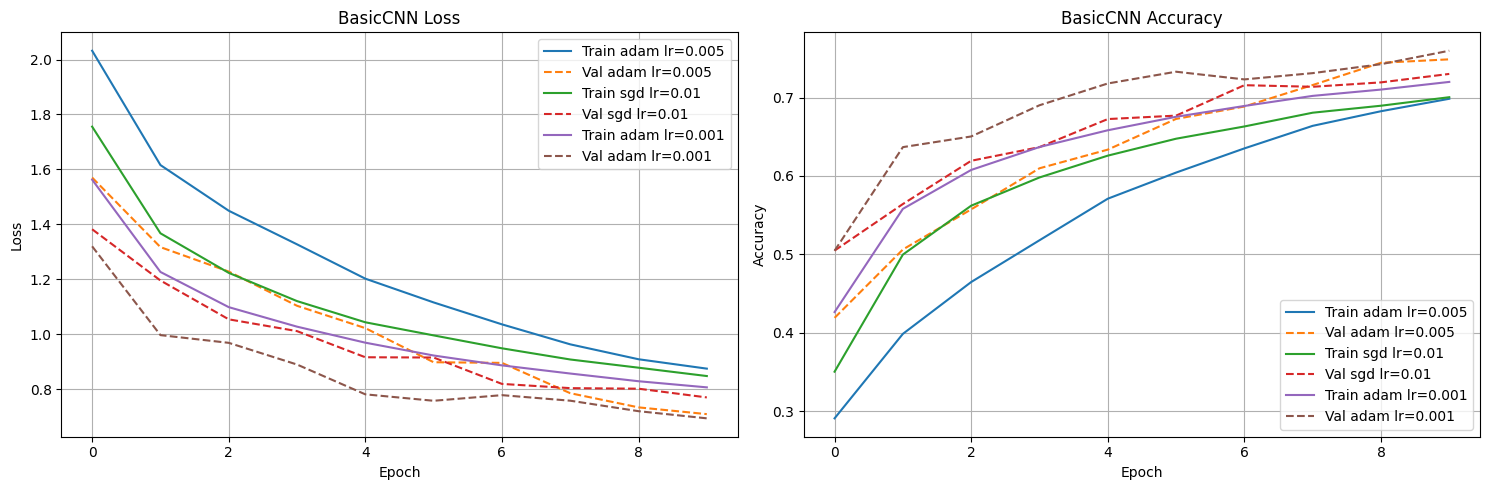

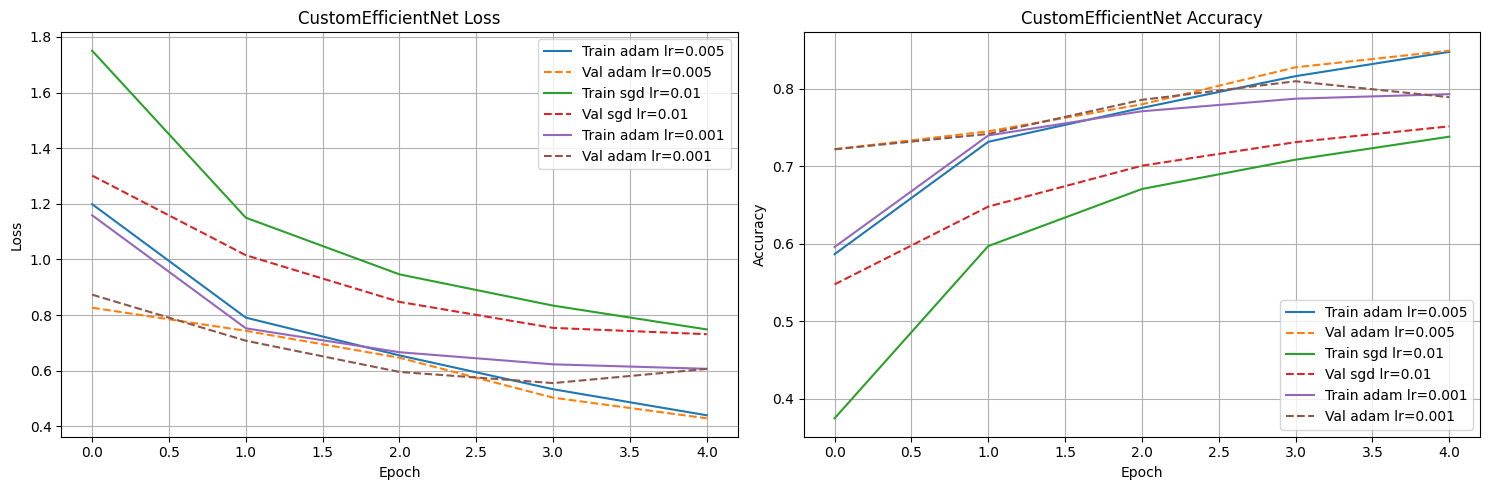

In [13]:
plot_training_history(results['BasicCNN'], 'BasicCNN')
plot_training_history(results['CustomEfficientNet'], 'CustomEfficientNet')

# 8. Demo Interface with Gradio

In [37]:
def create_demo(model):
    model.eval()

    def predict_image(img):
        # Preprocess the image
        transform = transforms.Compose([
            transforms.Resize((32, 32)),
            transforms.ToTensor(),
            transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616))
        ])

        img_tensor = transform(img).unsqueeze(0).to(device)

        # Get prediction
        with torch.no_grad():
            outputs = model(img_tensor)
            probs = F.softmax(outputs, dim=1)[0]
            probs = probs.cpu().numpy()

        # Return class probabilities
        return {class_names[i]: float(probs[i]) for i in range(len(class_names))}

    # Create Gradio interface
    demo = gr.Interface(
        fn=predict_image,
        inputs=gr.Image(type="pil"),
        outputs=gr.Label(num_top_classes=3),
        title="CIFAR-10 Image Classifier",
        description="Upload an image to see what class it belongs to.",

    )

    return demo

# To launch the demo, uncomment below after training the best model
best_model = overall_best_model['model']
demo = create_demo(best_model)
demo.launch()

It looks like you are running Gradio on a hosted a Jupyter notebook. For the Gradio app to work, sharing must be enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://2439648055b3221047.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
